# Generating Results for Project 2

This notebook includes all the code needed to run the calculations and simulations that I used in my second design project. This notebook also has the capability of simulating 2 two robots at the same time.
The notebook will first go through the calculations for LQR and then go through the simulation and results

First, we import all the required libraries

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy import linalg

# Given pybullet script (it is an interface to the pybullet simulator)
import ae353_segbot

import importlib
importlib.reload(ae353_segbot)

<module 'ae353_segbot' from 'c:\\Users\\anshu\\Desktop\\Class Materials\\AE 353 Git\\ae353-sp21\\projects\\02_segbot\\ae353_segbot.py'>

## Linearizing the System

First we need to setup the symbolic equations and linearize the system about an equilibrium point.

In [2]:
(e_l,
 e_h,
 v,
 w,
 theta,
 thetadot,
 tau_L,
 tau_R) = sym.symbols('e_l, e_h, v, w, theta, thetadot, tau_L, tau_R', real=True)

This large block bellow is taken mostly from the DeriveEOM notebook that was already provided. However, there were only 5 equation (theta wasn't part of the state) so I added that.

In [3]:
# Dimensions of chassis
dx = 0.4
dy = 0.6
dz = 0.8

# Distance between axle and COM of chassis
h = 0.3

# Half-distance between wheels
a = 0.7 / 2

# Mass of chassis
mb = 12.

# MOI of chassis
Jbx = (mb / 12) * (dy**2 + dz**2)
Jby = (mb / 12) * (dx**2 + dz**2)
Jbz = (mb / 12) * (dx**2 + dy**2)

# Radius of each wheel
r = 0.325

# Width of each wheel
hw = 0.075

# Mass of each wheel
mw = 1.2

# MOI of each wheel
Jw = (mw / 2) * r**2
Jwt = (mw / 12) * (3 * r**2 + hw**2)

# Total mass
m = mb + 2 * mw

# Total MOI
Jx = Jbx + 2 * Jwt
Jy = Jby
Jz = Jbz + 2 * Jwt

# Acceleration of gravity
g = 9.81

# Dimensions
h = sym.nsimplify(h)
a = sym.nsimplify(a)
r = sym.nsimplify(r)

# Masses
mb = sym.nsimplify(mb)
mw = sym.nsimplify(mw)
m = sym.nsimplify(m)

# MOIs
Jx = sym.nsimplify(Jx)
Jy = sym.nsimplify(Jy)
Jz = sym.nsimplify(Jz)
Jw = sym.nsimplify(Jw)
Jwt = sym.nsimplify(Jwt)

# Gravity
g = sym.nsimplify(g)

M = sym.Matrix([[m + 2 * Jw / r**2, 0, mb * h * sym.cos(theta)],
                [0, (Jx + mb * h**2) * sym.sin(theta)**2 + Jz * sym.cos(theta)**2 + (2 * Jw * a**2 / r**2) + 2 * mw * a**2, 0],
                [mb * h * sym.cos(theta), 0, Jy * mb * h**2]])
N = sym.Matrix([[mb * h * (w**2 + thetadot**2) * sym.sin(theta)],
                [-2 * (Jx - Jz + m * h**2) * sym.cos(theta) * sym.sin(theta) * w * thetadot - mb * h * sym.sin(theta) * v * w],
                [(Jx - Jz + mb * h**2) * sym.cos(theta) * sym.sin(theta) * w**2 + mb * g * h * sym.sin(theta)]])
R = sym.Matrix([[1 / r, 1 / r],
                [-a / r, a / r],
                [-1, -1]])
f = sym.simplify(M.inv() * (N + R * sym.Matrix([[tau_L], [tau_R]])))
# In the definition below for f, I added the 5th equation "thetadot" which is the derivative of theta, to complete my set of the equations of motion
f = sym.Matrix([[v * sym.sin(e_h)],
                [w],
                [f[0]],
                [f[1]],
                [thetadot],
                [f[2]]])

In [4]:
# See f
f

Matrix([
[                                                                                                                                                                              v*sin(e_h)],
[                                                                                                                                                                                       w],
[       -(2400*tau_L + 2400*tau_R + 2808*(thetadot**2 + w**2)*sin(theta) + 13*(250*tau_L + 250*tau_R - 195*w**2*sin(2*theta) - 8829*sin(theta))*cos(theta))/(11700*cos(theta)**2 - 12168)],
[                                                                       32*(-875*tau_L + 875*tau_R - 1443*thetadot*w*sin(2*theta) - 2925*v*w*sin(theta))/(13*(3120*sin(theta)**2 + 2051))],
[                                                                                                                                                                                thetadot],
[(42250*tau_L + 42250*tau_R - 32955*w**2*sin(2*thet

In [5]:
# Make f an executable function
f_num = sym.lambdify((e_l, e_h, v, w, theta, thetadot, tau_L, tau_R), f)

In [6]:
# Equilibrium values around which the system is linearized

e_l_e = 0
e_h_e = 0
v_e = 4 # Around the velocity that we want, can change this if needed
w_e = 0
theta_e = 0
thetadot_e = 0
tau_L_e = 0
tau_R_e = 0

In [7]:
# Checking if the equilibrium values work
f_eq = f_num(e_l_e, e_h_e, v_e, w_e, theta_e, thetadot_e, tau_L_e, tau_R_e)
f_eq #evaluates to 0! Nice!

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.]])

Now that we have the governing equations of motion and an equilibrium position, we can linearize the system about that equilibrium point.

In [8]:
#Now we find the Jacobians
f_jacob_x = f.jacobian([e_l, e_h, v, w, theta, thetadot])
f_jacob_u = f.jacobian([tau_L,tau_R])

#And then we find functions for A and B using this jacobian
A_num = sym.lambdify((e_l, e_h, v, w, theta, thetadot, tau_L, tau_R),f_jacob_x)
B_num = sym.lambdify((e_l, e_h, v, w, theta, thetadot, tau_L, tau_R),f_jacob_u)

#Finally, we find the linearized state space model by evaluating A_num and B_num at the equilibrium points
A = A_num(e_l_e, e_h_e, v_e, w_e, theta_e, thetadot_e, tau_L_e, tau_R_e).astype(float)
B = B_num(e_l_e, e_h_e, v_e, w_e, theta_e, thetadot_e, tau_L_e, tau_R_e).astype(float)

In [9]:
# See the linear system
A

array([[ 0.00000e+00,  4.00000e+00,  0.00000e+00,  0.00000e+00,
         0.00000e+00,  0.00000e+00],
       [ 0.00000e+00,  0.00000e+00,  0.00000e+00,  1.00000e+00,
         0.00000e+00,  0.00000e+00],
       [ 0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        -2.45250e+02, -0.00000e+00],
       [ 0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
         0.00000e+00,  0.00000e+00],
       [ 0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
         0.00000e+00,  1.00000e+00],
       [ 0.00000e+00,  0.00000e+00,  0.00000e+00, -0.00000e+00,
         1.06275e+03, -0.00000e+00]])

In [10]:
B

array([[  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [ 12.07264957,  12.07264957],
       [ -1.05014439,   1.05014439],
       [  0.        ,   0.        ],
       [-51.46011396, -51.46011396]])

## Checking Controllability

We need to check if our system is controllable or not before we start designing a controller. For this, we calculate the $$W$$ matrix and check its rank.

In [11]:
# Find the number of states
n = A.shape[0]

# Initialize W with its first column
W = B

# Create W one column at a time by iterating over i from 1 to n-1
for i in range(1, n):
    col = np.linalg.matrix_power(A, i) @ B
    W = np.block([W, col])
    

In [12]:
W

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -4.20057758e+00,  4.20057758e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -1.05014439e+00,
         1.05014439e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.20726496e+01,  1.20726496e+01,  0.00000000e+00,
         0.00000000e+00,  1.26205929e+04,  1.26205929e+04,
         0.00000000e+00,  0.00000000e+00,  1.34125352e+07,
         1.34125352e+07,  0.00000000e+00,  0.00000000e+00],
       [-1.05014439e+00,  1.05014439e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -5.1460114

In [13]:
# What about the rank?
print(np.linalg.matrix_rank(W))


6


We see that the rank of the controllability matrix is equal to the number of states in the system. This means that our chosen system is controllable! Perfect. We can now move on to the next step, designing an appropriate controller using LQR.

## Finding controller gains using LQR
The main additional matrices that LQR requires are the Q and the R matrices, which are the error-cost and the effort-cost matrices respecively. Finding these is a manual task that requires some testing to find sensible gains that meet our requirements.
As such, the cost matrices seen below were derived after a lot of testing.
After finding Q and R, we use the absolute ricatti equation to solve for P and then find K.

In [14]:
Q = np.diag([30,17.5,2,20,60,40]) # Lateral error, heading error, forward speed, turning rate, pitch, pitch rate
R = np.diag([1.,1.])

P = linalg.solve_continuous_are(A, B, Q, R)
K = linalg.inv(R) @  B.T @ P

In [15]:
# Let's see K
K.tolist()

[[-3.8729833462074224,
  -12.385264813293158,
  -1.0,
  -4.668390345553613,
  -23.571117399396655,
  -4.763739354314854],
 [3.8729833462074366,
  12.385264813293228,
  -0.9999999999999716,
  4.668390345553661,
  -23.571117399396655,
  -4.763739354314847]]

Just in case, let us check the eigenvalues of the system.

In [16]:
# Check stability of the K calculated above
F  = A - B@K
s = linalg.eigvals(F)
print(s.real)

[-6.61685967e+00 -1.59405412e+00 -1.59405412e+00 -4.63198793e+02
 -2.59184571e+00 -3.49201891e-01]


In [17]:
# Let's check the imaginary components too
print(s.imag)

[ 0.          1.54154451 -1.54154451  0.          0.          0.        ]


Looks like all our eigenvalues have negative real parts but a few have imaginary parts. This means that we'll get some oscillation, but we should generally have a stable system.

In [18]:
# F = sym.simplify(sym.Matrix(F))
# x0 = np.array([[0],[0],[0],[0],[0],[0]])
# t = sym.Symbol('t')
# sym.exp(-F*t)

## Simulating our System
With a decided K value, we can now run our system in the segbot simulation. This simulation is different from the original as it accomodates for two robots  that can take two different controllers if that condition is set to be true. The simulation has more fun models :)

Create an instance of the robot simulator. This will open a window in which you should see the segbot.

There are four optional parameters:

* `damping` is the coefficient of viscous friction at each wheel joint (the default value is `0.`)
* `dt` is the length of each time step in the simulator (the default value is `0.01`)
* `two_robots` will change the number of robots in the simulation from 1 to 2
* `display` is a flag that says whether or not to open the GUI (the default value is `True`)

In [19]:
two_robots = True

In [20]:
robot = ae353_segbot.RobotSimulator(damping=0., dt=0.01, two_robots=two_robots, display=True)

Below, we set different K values for the 2 robots if required. If not, we can just set them both to the same value.

In [21]:
K1 = K
K2 = K

Next, we define two different controllers for the two different robots. Again, the reason this exists is because I could test two controller simultaneously and compare easily.

In [22]:
class RobotController1:
    def __init__(self, dt=0.01, K = K1):
        self.dt = dt
        self.v_des = 4
        self.e_l_des = -0.3
        self.K = K

    def run(self, lateral_error, heading_error, forward_speed, turning_rate, pitch_angle, pitch_rate):
        x = np.array([[lateral_error-self.e_l_des], [heading_error], [forward_speed - self.v_des], [turning_rate], [pitch_angle], [pitch_rate]])
        u = -self.K @ x

        tau_left = u[0] # <-- Torque to left wheel
        tau_right = u[1] # <-- Torque to right wheel
        
        return tau_left, tau_right

controller1 = RobotController1(dt=robot.dt)

################################################

#Controller for robot 2
class RobotController2:
    def __init__(self, dt=0.01, K = K2):
        self.dt = dt
        self.v_des = 4
        self.e_l_des = -0.3
        self.K = K

    def run(self, lateral_error, heading_error, forward_speed, turning_rate, pitch_angle, pitch_rate):
        x = np.array([[lateral_error-self.e_l_des], [heading_error], [forward_speed - self.v_des], [turning_rate], [pitch_angle], [pitch_rate]])
        u = -self.K @ x

        tau_left = u[0] # <-- Torque to left wheel
        tau_right = u[1] # <-- Torque to right wheel
        
        return tau_left, tau_right

controller2 = RobotController2(dt=robot.dt)

Run the simulation. It is a loop. At each iteration, we:
* get sensor measurements
* choose actuator commands
* go forward one time step

We also log data so that we can plot it later, if we want.

In [23]:
# Restore the simulation to its initial state
robot.reset(turn_left=False,            # does the robot turn left or right around the track
            ground_pitch=0.0,            # angle that the track is sloped (rad)
            initial_speed=0.0,           # initial forward speed of segbot (m/s)
            initial_lateral_error=0.,   # initial lateral error of segbot (m)
            initial_heading_error=0.,   # initial heading error of segbot (rad)
            initial_pitch=0.)           # initial pitch angle of chassis (rad)

# Choose a camera view
# robot.camera_sideview()
# robot.camera_topview()
# robot.camera_chaseview(yaw=270.) # For robot 1, robot 2 camera not set up yet.


# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time = 80.
num_steps = int(run_time/robot.dt)

if (two_robots):
    # Create a dictionary in which to store results
    data = {
        't': np.empty(num_steps, dtype=float),
        'lateral_error1': np.empty(num_steps, dtype=float),
        'heading_error1': np.empty(num_steps, dtype=float),
        'forward_speed1': np.empty(num_steps, dtype=float),
        'turning_rate1': np.empty(num_steps, dtype=float),
        'pitch_angle1': np.empty(num_steps, dtype=float),
        'pitch_rate1': np.empty(num_steps, dtype=float),
        'tau_left_command1': np.empty(num_steps, dtype=float),
        'tau_right_command1': np.empty(num_steps, dtype=float),
        'tau_left1': np.empty(num_steps, dtype=float),
        'tau_right1': np.empty(num_steps, dtype=float),
        'lateral_error2': np.empty(num_steps, dtype=float),
        'heading_error2': np.empty(num_steps, dtype=float),
        'forward_speed2': np.empty(num_steps, dtype=float),
        'turning_rate2': np.empty(num_steps, dtype=float),
        'pitch_angle2': np.empty(num_steps, dtype=float),
        'pitch_rate2': np.empty(num_steps, dtype=float),
        'tau_left_command2': np.empty(num_steps, dtype=float),
        'tau_right_command2': np.empty(num_steps, dtype=float),
        'tau_left2': np.empty(num_steps, dtype=float),
        'tau_right2': np.empty(num_steps, dtype=float),
    }
else:
    data = {
        't': np.empty(num_steps, dtype=float),
        'lateral_error1': np.empty(num_steps, dtype=float),
        'heading_error1': np.empty(num_steps, dtype=float),
        'forward_speed1': np.empty(num_steps, dtype=float),
        'turning_rate1': np.empty(num_steps, dtype=float),
        'pitch_angle1': np.empty(num_steps, dtype=float),
        'pitch_rate1': np.empty(num_steps, dtype=float),
        'tau_left_command1': np.empty(num_steps, dtype=float),
        'tau_right_command1': np.empty(num_steps, dtype=float),
        'tau_left1': np.empty(num_steps, dtype=float),
        'tau_right1': np.empty(num_steps, dtype=float)
    }

# Run the simulation loop
start_time = time.time()
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    
    # Get the sensor measurements
    (lateral_error1,
     heading_error1,
     forward_speed1,
     turning_rate1,
     pitch_angle1,
     pitch_rate1) = robot.get_sensor_measurements(robot.robot1_id,robot.joint_ids1)

    
    # Choose the actuator command (by running the controller) for robot 1
    tau_left_command1, tau_right_command1 = controller1.run(lateral_error1,
                                                         heading_error1,
                                                         forward_speed1,
                                                         turning_rate1,
                                                         pitch_angle1,
                                                         pitch_rate1)
    
    # Apply the actuator commands for robot 1
    tau_left1, tau_right1 = robot.set_actuator_commands(robot.robot1_id, robot.joint_ids1, tau_left_command1, tau_right_command1)
    
    # Log the data for robot 1 from this time step
    data['t'][step] = t
    data['lateral_error1'][step] = lateral_error1
    data['heading_error1'][step] = heading_error1
    data['forward_speed1'][step] = forward_speed1
    data['turning_rate1'][step] = turning_rate1
    data['pitch_angle1'][step] = pitch_angle1
    data['pitch_rate1'][step] = pitch_rate1
    data['tau_left_command1'][step] = tau_left_command1
    data['tau_right_command1'][step] = tau_right_command1
    data['tau_left1'][step] = tau_left1
    data['tau_right1'][step] = tau_right1
    
    if (two_robots):
        # Get the sensor measurements
        (lateral_error2,
        heading_error2,
        forward_speed2,
        turning_rate2,
        pitch_angle2,
        pitch_rate2) = robot.get_sensor_measurements(robot.robot2_id,robot.joint_ids2)

         # Choose the actuator command (by running the controller) for robot 2
        tau_left_command2, tau_right_command2 = controller2.run(lateral_error2,
                                                            heading_error2,
                                                            forward_speed2,
                                                            turning_rate2,
                                                            pitch_angle2,
                                                            pitch_rate2)
        

        # Apply the actuator commands for robot 2
        tau_left2, tau_right2 = robot.set_actuator_commands(robot.robot2_id, robot.joint_ids2, tau_left_command2, tau_right_command2)

        # Log the data for robot 2 from this time step
        data['lateral_error2'][step] = lateral_error2
        data['heading_error2'][step] = heading_error2
        data['forward_speed2'][step] = forward_speed2
        data['turning_rate2'][step] = turning_rate2
        data['pitch_angle2'][step] = pitch_angle2
        data['pitch_rate2'][step] = pitch_rate2
        data['tau_left_command2'][step] = tau_left_command2
        data['tau_right_command2'][step] = tau_right_command2
        data['tau_left2'][step] = tau_left2
        data['tau_right2'][step] = tau_right2
    
    # Simulate one time step
    robot.step(t=(start_time + (robot.dt * (step + 1))))

## Plotting the results
Some of the axes are limited to help in the verification of our requirements

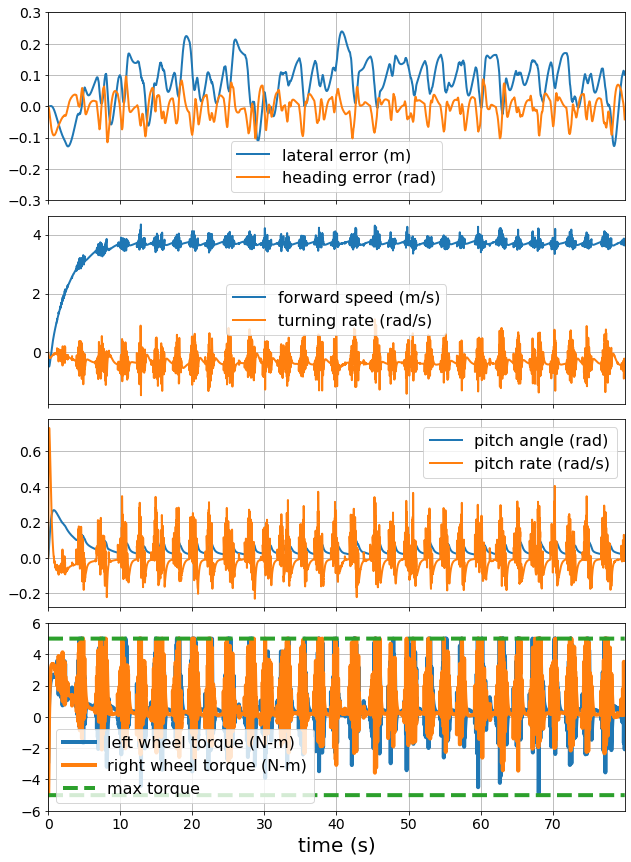

In [24]:
# Create a figure with four subplots, all of which share the same x-axis
fig, ax = plt.subplots(4, 1, figsize=(9, 12), sharex=True)

# First subplot
ax[0].plot(data['t'], data['lateral_error1'], label='lateral error (m)', linewidth=2)
ax[0].plot(data['t'], data['heading_error1'], label='heading error (rad)', linewidth=2)
ax[0].grid()
ax[0].legend(fontsize=16)
ax[0].tick_params(labelsize=14)
ax[0].set_ylim(-0.3,0.3)


# Second subplot
ax[1].plot(data['t'], data['forward_speed1'], label='forward speed (m/s)', linewidth=2)
ax[1].plot(data['t'], data['turning_rate1'], label='turning rate (rad/s)', linewidth=2)
ax[1].grid()
ax[1].legend(fontsize=16)
ax[1].tick_params(labelsize=14)

# Third subplot
ax[2].plot(data['t'], data['pitch_angle1'], label='pitch angle (rad)', linewidth=2)
ax[2].plot(data['t'], data['pitch_rate1'], label='pitch rate (rad/s)', linewidth=2)
ax[2].grid()
ax[2].legend(fontsize=16)
ax[2].tick_params(labelsize=14)

# Fourth subplot
ax[3].plot(data['t'], data['tau_left1'], label='left wheel torque (N-m)', linewidth=4)
ax[3].plot(data['t'], data['tau_right1'], label='right wheel torque (N-m)', linewidth=4)
ax[3].plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max torque', linewidth=4, color='C2')
ax[3].plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C2')
ax[3].grid()
ax[3].legend(fontsize=16)
ax[3].tick_params(labelsize=14)
ax[3].set_ylim(-1.2 * robot.tau_max, 1.2 * robot.tau_max)

# Set x-axis properties (only need to do this on the fourth
# subplot since all four subplots share the same x-axis)
ax[3].set_xlabel('time (s)', fontsize=20)
ax[3].set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

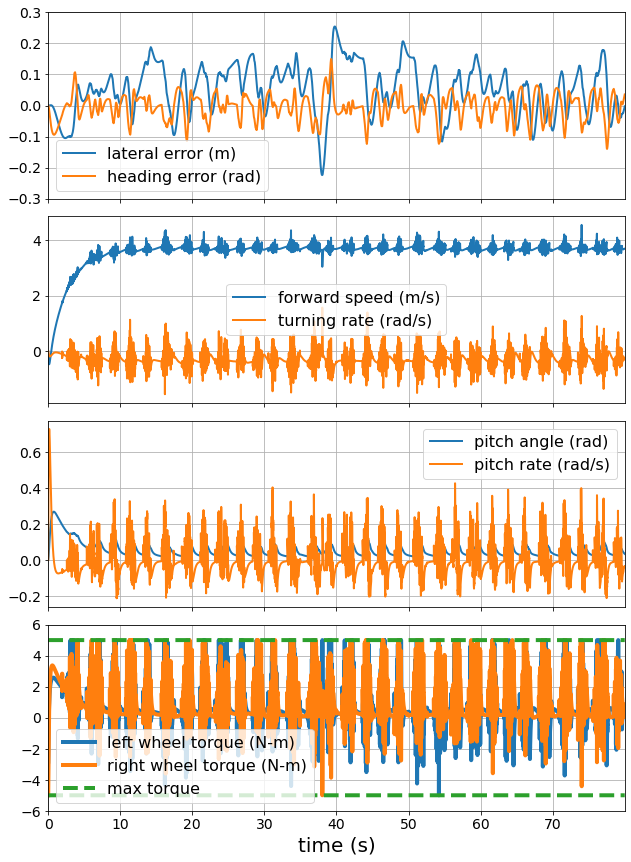

In [25]:
if (two_robots):
    # Create a figure with four subplots, all of which share the same x-axis
    fig, ax = plt.subplots(4, 1, figsize=(9, 12), sharex=True)

    # First subplot
    ax[0].plot(data['t'], data['lateral_error2'], label='lateral error (m)', linewidth=2)
    ax[0].plot(data['t'], data['heading_error2'], label='heading error (rad)', linewidth=2)
    ax[0].grid()
    ax[0].legend(fontsize=16)
    ax[0].tick_params(labelsize=14)
    ax[0].set_ylim(-0.3,0.3)

    # Second subplot
    ax[1].plot(data['t'], data['forward_speed2'], label='forward speed (m/s)', linewidth=2)
    ax[1].plot(data['t'], data['turning_rate2'], label='turning rate (rad/s)', linewidth=2)
    ax[1].grid()
    ax[1].legend(fontsize=16)
    ax[1].tick_params(labelsize=14)

    # Third subplot
    ax[2].plot(data['t'], data['pitch_angle2'], label='pitch angle (rad)', linewidth=2)
    ax[2].plot(data['t'], data['pitch_rate2'], label='pitch rate (rad/s)', linewidth=2)
    ax[2].grid()
    ax[2].legend(fontsize=16)
    ax[2].tick_params(labelsize=14)

    # Fourth subplot
    ax[3].plot(data['t'], data['tau_left2'], label='left wheel torque (N-m)', linewidth=4)
    ax[3].plot(data['t'], data['tau_right2'], label='right wheel torque (N-m)', linewidth=4)
    ax[3].plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max torque', linewidth=4, color='C2')
    ax[3].plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C2')
    ax[3].grid()
    ax[3].legend(fontsize=16)
    ax[3].tick_params(labelsize=14)
    ax[3].set_ylim(-1.2 * robot.tau_max, 1.2 * robot.tau_max)

    # Set x-axis properties (only need to do this on the fourth
    # subplot since all four subplots share the same x-axis)
    ax[3].set_xlabel('time (s)', fontsize=20)
    ax[3].set_xlim([data['t'][0], data['t'][-1]])

    # Make the arrangement of subplots look nice
    fig.tight_layout()